In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import mediapy as media
import torch
from hydra import compose, initialize
from neural_jacobian_field.config.common import PipelineCfg, get_typed_root_config
from neural_jacobian_field.data.data_module import DATASETS
from neural_jacobian_field.data.dataset.dataset import DatasetItems
from neural_jacobian_field.models.model import (
    CameraInput,
    Model,
    RenderingInput,
    RobotInput,
)
from neural_jacobian_field.models.model_wrapper import ModelWrapper
from neural_jacobian_field.rendering import geometry
from neural_jacobian_field.utils import convention
from neural_jacobian_field.utils.wandb_ckpt import update_checkpoint_path

In [3]:
from neural_jacobian_field.data.data_module import DatasetCommon

model_name = "model_allegro"
dataset_name = "dataset_allegro"
action_decoder_name = "jacobian_transformer"
checkpoint_path = "./inference_demo_data/pretrained_ckpts/d7xlr8vp/model.ckpt"


config_path = Path("project/neural_jacobian_field/configurations/config")

dataset_config_path = Path("./dataset_configs/allegro_config.json")

overrides = [
    f"model={model_name}",
    f"dataset={dataset_name}",
    f"dataset.root={dataset_config_path}",
    f"dataset.other_roots=null",
    f"dataset.augment_ctxt_image=False",
    f"dataset.augment_lighting=False",
    f"model.action_decoder.name={action_decoder_name}",
    f"model.rendering.num_proposal_samples=[256]",
    f"model.rendering.num_nerf_samples=256",
]

map_to_root = Path("../../")
with initialize(version_base=None, config_path=str(map_to_root / config_path.parent)):
    hydra_cfg = compose(config_name=str(config_path.name), overrides=overrides)

cfg: PipelineCfg = get_typed_root_config(hydra_cfg, PipelineCfg)

dataset: DatasetCommon = DATASETS[cfg.dataset.name](cfg=cfg.dataset, stage="train")
model = Model(cfg.model)
wrapper = ModelWrapper(cfg=cfg, model=model)

/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field-public/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [4]:
checkpoint = torch.load(checkpoint_path)

wrapper.load_state_dict(checkpoint["state_dict"])
wrapper.eval()

ModelWrapper(
  (model): Model(
    (encoder): EncoderResnet(
      (model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

### Move to gpu and load near and far bounds

In [5]:
device = torch.device("cuda:0")

wrapper.to(device)
z_near = torch.tensor([dataset.near], device=device)
z_far = torch.tensor([dataset.far], device=device)
dataset_items: DatasetItems = dataset.dataset_items
ctxt_camera_index = 1
trgt_camera_index = 1

### Load camera data

In [6]:
ctxt_intrinsics, (render_height, render_width) = dataset.load_intrinsics(
    ctxt_camera_index
)
trgt_intrinsics, _ = dataset.load_intrinsics(trgt_camera_index)

ctxt_intrinsics = ctxt_intrinsics.to(device)
trgt_intrinsics = trgt_intrinsics.to(device)

ctxt_extrinsics = dataset.load_extrinsics(ctxt_camera_index).to(device)
trgt_extrinsics = dataset.load_extrinsics(trgt_camera_index).to(device)

ctxt_extrinsics, trgt_extrinsics = dataset.get_relative_transform(
    ctxt_extrinsics, trgt_extrinsics
)
coordinates, _ = geometry.get_pixel_coordinates(
    height=render_height, width=render_width, device=device
)

ctxt_extrinsics = ctxt_extrinsics.unsqueeze(0)
trgt_extrinsics = trgt_extrinsics.unsqueeze(0)

ctxt_intrinsics = ctxt_intrinsics.unsqueeze(0)
trgt_intrinsics = trgt_intrinsics.unsqueeze(0)

### Load example input image

In [ ]:
from neural_jacobian_field.utils import io_utils

demo_data = io_utils.load_gzip_file(
    Path("./inference_demo_data/optimization_demo_allegro_hand.pkl")
)


input_curr_tracks_np = demo_data["curr_pix_locs"].copy()
input_trgt_tracks_np = demo_data["trgt_pix_locs"].copy()
input_image_np = demo_data["curr_frame"].copy()
gt_optical_flow_np = demo_data["gt_optical_flow"].copy()

input_image_th = io_utils.numpy_to_torch_image(input_image_np).to(device).unsqueeze(0)

# Drawing desired motions!

- Desired motions are expressed as the motion vector (input_trgt_tracks_np - input_curr_tracks_np), which is of shape (num_points, 2).
- Let's visualize our desired motions by overlaying these motion vectors on the original image!

""

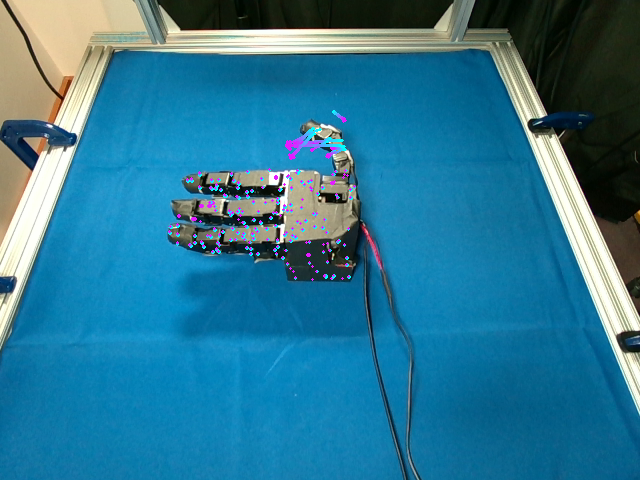

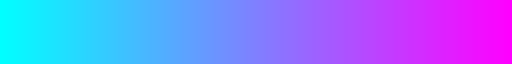

In [9]:
import mediapy as media

from matplotlib import cm
from neural_jacobian_field.inference import plotting

# this model is only trained on hand motions only, so it is not sensitivty to the arm
point_matching_image_np = plotting.draw_point_matching_on_image(
    input_image_np,
    curr_pix_locs=input_curr_tracks_np,
    trgt_pix_locs=input_trgt_tracks_np,
    color_map_choice="cool",
    line_thickness=2,
)

render_height, render_width = input_image_np.shape[:2]

media.show_image(
    point_matching_image_np,
    height=render_height // 1,
    width=render_width // 1,
)

cm.get_cmap("cool")

In [10]:
image_height, image_width = input_image_th.shape[-2:]

origins, directions, z_values = geometry.get_world_rays_with_z(
    coordinates.view(1, -1, 2),
    trgt_intrinsics,
    trgt_extrinsics,
)

### Volume render the Jacobian Fields 

- This step is slow because of volume rendering. However, note that **volume rendering is only necessary for visualization purposes**. 
- For control purposes, gradient-based optimization of robot commands can be run at 12 hz and real-time if least square solver is used.


In [11]:
action_dim = model.decoder.action_dim
robot_action_th = torch.zeros((1, action_dim), device=device)


In [12]:
with torch.no_grad():
    rendering_outputs = model.patch_render(
        camera_input=CameraInput(
            input_image=input_image_th,
            ctxt_extrinsics=ctxt_extrinsics,
            ctxt_intrinsics=ctxt_intrinsics,
            trgt_extrinsics=trgt_extrinsics,
            trgt_intrinsics=convention.denormalize_intrinsics(
                trgt_intrinsics, width=image_width, height=image_height
            ),
        ),
        rendering_input=RenderingInput(
            origins=origins,
            directions=directions,
            z_near=z_near + torch.ones_like(z_near) * 0.15,
            z_far=torch.ones_like(z_far) * 3.2,
        ),
        robot_input=RobotInput(
            robot_action=robot_action_th,
        ),
        verbose=True,
    )

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:18<00:00,  7.95it/s]


### Visualize the Jacobian Image 

- After volume rendering, the Jacobian image is of shape `H x W x Spatial Dim x Action Dim`. In this case spatial dim is projected from three dimensions to two dimensions.
- We compute norm over the spatial dimension to get a measurement of how sensitive each pixel is w.r.t each robot command channel.


In [13]:
from neural_jacobian_field.inference.jacobian_color_map import (
    JACOBIAN_COLORMAP,
    visualize_joint_sensitivity,
    visualize_jacobian_chain_structure,
    compute_joint_sensitivity,
)

joint_sensitivity_th = compute_joint_sensitivity(
    jacobians=rendering_outputs.action_features, extrinsics=trgt_extrinsics
)


print(rendering_outputs.action_features.shape)
print(joint_sensitivity_th.shape)

torch.Size([1, 480, 640, 24])
torch.Size([1, 8, 480, 640])


### Visualize the Jacobian Image 

- For every command channel, for visualization purpose, we assign a color component for that channel. `JACOBIAN_COLORMAP`
- We now can convert the sensitvity image to a meaningful visualization of how sensitive pixel is for a command channel. 


In [14]:
model_name

'model_allegro'

In [15]:
jacobian_colormap = torch.tensor(
    JACOBIAN_COLORMAP[model_name], device=device, dtype=torch.float32
).T


rendering_outputs.action_features.shape

torch.Size([1, 480, 640, 24])

In [16]:
jacobian_colormap.shape

torch.Size([3, 8])

In [17]:
joint_sensitivity_th = compute_joint_sensitivity(
    jacobians=rendering_outputs.action_features, extrinsics=trgt_extrinsics
)

jacobian_vis_np = visualize_joint_sensitivity(joint_sensitivity_th, jacobian_colormap)

depth_pred,jacobian_vis

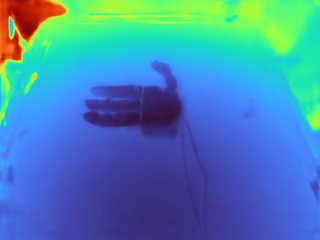
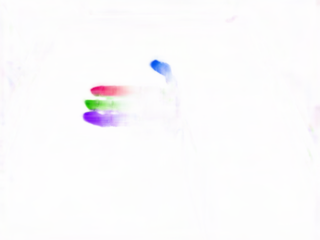

In [29]:
media.show_images(
    [
        rendering_outputs.depth_rgb[0].cpu().numpy(),
        jacobian_vis_np[0],
    ],
    height=image_height // 2,
    width=image_width // 2,
    titles=[
        "depth_pred",
        "jacobian_vis",
    ]
)

### Solving inverse dynamics



In [19]:
import tqdm
import numpy as np
import torch.nn as nn
from neural_jacobian_field.utils import convention

action_dim = 8
action_init_var = 0.01

reg_multiplier: float = 0.000
return_history: bool = False

num_optim_iter: int = 100
learning_rate: float = 1e-1

trgt_pix_flow = input_trgt_tracks_np - input_curr_tracks_np
# casting everything to torch
curr_pix_locs_th = torch.from_numpy(np.asarray(input_curr_tracks_np)).to(device).float()
trgt_pix_flow_th = torch.from_numpy(np.asarray(trgt_pix_flow)).to(device).float()

image_height, image_width = input_image_th.shape[-2:]

# create index selector
pixel_locations_t0 = curr_pix_locs_th[:, :].to(torch.long)
index_selector_t0 = pixel_locations_t0[..., 0]
index_selector_t0 += image_width * pixel_locations_t0[..., 1]

# create action param
action_param = torch.randn((1, action_dim), device=device)
action_param *= action_init_var
action_param = nn.Parameter(action_param)

# create optimizer
optim = torch.optim.Adam([action_param], lr=learning_rate)
ran = tqdm.trange(num_optim_iter)

camera_input = CameraInput(
    input_image=input_image_th,
    ctxt_extrinsics=ctxt_extrinsics,
    ctxt_intrinsics=ctxt_intrinsics,
    trgt_extrinsics=trgt_extrinsics,
    trgt_intrinsics=convention.denormalize_intrinsics(
        trgt_intrinsics, width=image_width, height=image_height
    ),
)
with torch.no_grad():
    inference_encoding = model.encode_image(
        camera_input=camera_input,
        rendering_input=RenderingInput(
            origins=origins[:, index_selector_t0, :],
            directions=directions[:, index_selector_t0, :],
            z_near=z_near,  # TODO: careful with this
            z_far=z_far,
        ),
        robot_input=RobotInput(
            robot_action=action_param,
        ),
    )

action_history = [] if return_history else None
best_param = None
best_loss = float("inf")
for i in ran:
    optim.zero_grad()
    pred_flow = model.infer_optical_flow(
        model_inference_encoding=inference_encoding,
        camera_input=camera_input,
        robot_input=RobotInput(
            robot_action=action_param,
        ),
    )

    loss = torch.nn.functional.smooth_l1_loss(
        pred_flow,
        trgt_pix_flow_th,
        reduction="mean",
    )

    # regularize dq
    dq_reg = reg_multiplier * action_param.pow(2).mean()
    loss += dq_reg

    loss.backward()
    optim.step()
    ran.set_description_str(f"loss: {loss.item()} | dq_reg: {dq_reg}")

    if action_history is not None:
        action_history.append(action_param.detach().clone())

    if best_param is None or loss.item() < best_loss:
        best_param = action_param.detach().clone()
        best_loss = loss.item()

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_1195736/3896678876.py:72: UserWarning: Using a target size (torch.Size([200, 2])) that is different to the input size (torch.Size([1, 200, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.smooth_l1_loss(
loss: 0.8866563439369202 | dq_reg: 0.0: 100%|██████████| 100/100 [00:00<00:00, 546.05it/s]


In [20]:
print(best_param.cpu().numpy())


[[ 0.03398551  0.02780277 -0.1156489   0.3046276   0.02384015 -0.04065165
   0.4035833  -0.00265105]]


### Render the optimized action's flow prediction


In [25]:
with torch.no_grad():
    rendering_outputs = model.patch_render(
        camera_input=CameraInput(
            input_image=input_image_th,
            ctxt_extrinsics=ctxt_extrinsics,
            ctxt_intrinsics=ctxt_intrinsics,
            trgt_extrinsics=trgt_extrinsics,
            trgt_intrinsics=convention.denormalize_intrinsics(
                trgt_intrinsics, width=image_width, height=image_height
            ),
        ),
        rendering_input=RenderingInput(
            origins=origins,
            directions=directions,
            z_near=z_near + torch.ones_like(z_near) * 0.15,
            z_far=torch.ones_like(z_far) * 3.2,
        ),
        robot_input=RobotInput(
            robot_action=best_param.detach(),
        ),
        verbose=True,
    )

100%|██████████| 150/150 [00:18<00:00,  7.98it/s]


### Conclusion 

Indeed! We observe that the first two command channels have very large magnitudes. These two channels correspond to the motors on the first finger. This proof of concept shows that our model can solve for robot command.

GT Optical Flow (inferred from gt video),Pred Optical Flow

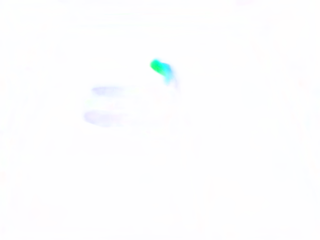
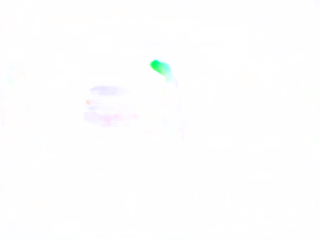

In [27]:
media.show_images(
    [gt_optical_flow_np, rendering_outputs.flow_rgb[0].cpu().numpy()],
    height=render_height // 2,
    width=render_width // 2,
    titles=["GT Optical Flow (inferred from gt video)", "Pred Optical Flow"],
)